## Part 3: Building a Recommender System with Implicit Feedback

In [1]:
import pandas as pd

In [2]:
artists = pd.read_csv("data/lastfm/artists.txt", sep='\t')

data = pd.read_csv("data/lastfm/user_artists.txt", sep='\t')

In [4]:
artist_tags = pd.read_csv("data/lastfm/user_taggedartists.txt", sep='\t')

In [5]:
tags = pd.read_csv("data/lastfm/tags.txt", sep='\t', encoding='latin-1')

In [6]:
artist_tags = artist_tags.merge(tags, on='tagID')

In [7]:
artist_tags

artist_tags['tags'] = artist_tags.groupby('artistID')['tagValue'].apply(lambda x: list(set(x)))

### How many users and artists are in our dataset?

In [11]:
n_users = data['userID'].nunique()
n_artists = data['artistID'].nunique()

print(f"Number of unique users: {n_users}")
print(f"Number of unique artists: {n_artists}")

Number of unique users: 1892
Number of unique artists: 17632


### How many artists does a user listen to on average?

First, we need to figure out how our data is organized.

In [12]:
number_of_listens = data.groupby('userID')['artistID'].count()
number_of_artists = data.groupby('userID')['artistID'].nunique()

(number_of_artists == number_of_listens).value_counts()

True    1892
Name: artistID, dtype: int64

In [13]:
listens_by_user = number_of_listens.reset_index()
listens_by_user.columns = ['userID', 'n_user_listens']

listens_by_user['n_user_listens'].describe()

count    1892.000000
mean       49.066596
std         5.845879
min         1.000000
25%        50.000000
50%        50.000000
75%        50.000000
max        50.000000
Name: n_user_listens, dtype: float64

### How many users listened to a given artist?

In [14]:
listens_by_artist = data.groupby('artistID')['userID'].count().reset_index()
listens_by_artist.columns = ['artistID', 'n_artist_listens']

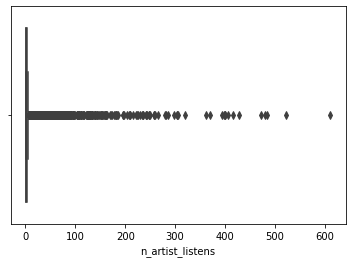

In [16]:
import seaborn as sns
sns.boxplot(listens_by_artist['n_artist_listens'])

In [20]:
p_single_listens = (listens_by_artist['n_artist_listens']==1).sum()/listens_by_artist['artistID'].nunique()
print(f"Percentage of artists that were only listened once: {p_single_listens:.2%}")

mean_number_of_listeners = listens_by_artist['n_artist_listens'].mean()
print(f"Mean number of listeners for a given artist: {mean_number_of_listeners:.2f}")

print(f"Max number of listeners for a given artist: {listens_by_artist['n_artist_listens'].max()}")

Percentage of artists that were only listened once: 60.57%
Mean number of listeners for a given artist: 5.27
Mean max number of listeners for a given artist: 611


### Filtering the data

We're going to filter the data to include:

- artists that were listened to by 5 or more users 
- users that listened to 10 or more artists


In [27]:
artists_with_5_or_more_listens = listens_by_artist[listens_by_artist['n_artist_listens']>=5]
users_with_25_or_more_listens = listens_by_user[listens_by_user['n_user_listens']>=25]

In [65]:
data_filtered = data.merge(artists_with_5_or_more_listens, how='right').merge(users_with_25_or_more_listens, how='right')

data_filtered = data_filtered.dropna(subset=['userID', 'artistID'])

In [66]:
print(f"Original number of user-artist interactions: {data.shape[0]}")
print(f"New number of user-artist interactions: {data_filtered.shape[0]}")
print(f"Number of user-artist interactions removed: {data.shape[0]-data_filtered.shape[0]}")

Original number of user-artist interactions: 92834
New number of user-artist interactions: 71241
Number of user-artist interactions removed: 21593


In [72]:
from scipy.sparse import csr_matrix
import numpy as np

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userID'].nunique()
    M = df['artistID'].nunique()
    
    user_col = df["userID"]
    item_col = df["artistID"]
    
    user_mapper = dict(zip(np.unique(user_col), list(range(N))))
    movie_mapper = dict(zip(np.unique(item_col), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userID"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["artistID"])))
    
    user_index = [user_mapper[i] for i in df['userID']]
    movie_index = [movie_mapper[i] for i in df['artistID']]

    X = csr_matrix((df["weight"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [74]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(data_filtered)

In [75]:
X.shape

(2828, 1856)

In [ ]:
# from implicit.als import AlternatingLeastSquares

# model = AlternatingLeastSquares(factors=50)

# train the model on a sparse matrix of item/user/confidence weights
# model.fit(X)

import implicit

# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=50)


In [54]:
from collections import Counter

tag_counts = Counter(t for tags in artist_tags['tags'].dropna() for t in tags)

In [57]:
tag_counts.most_common(50)

[('rock', 2283),
 ('electronic', 1749),
 ('alternative', 1743),
 ('pop', 1739),
 ('indie', 1537),
 ('female vocalists', 1395),
 ('seen live', 1014),
 ('experimental', 962),
 ('dance', 942),
 ('alternative rock', 875),
 ('singer-songwriter', 872),
 ('80s', 812),
 ('ambient', 791),
 ('90s', 784),
 ('indie rock', 765),
 ('electronica', 759),
 ('chillout', 733),
 ('instrumental', 682),
 ('british', 681),
 ('folk', 664),
 ('male vocalists', 652),
 ('metal', 644),
 ('00s', 642),
 ('acoustic', 592),
 ('soundtrack', 590),
 ('american', 581),
 ('hip-hop', 566),
 ('punk', 533),
 ('hard rock', 500),
 ('new wave', 488),
 ('classic rock', 474),
 ('beautiful', 464),
 ('indie pop', 462),
 ('cover', 461),
 ('mellow', 457),
 ('awesome', 454),
 ('jazz', 446),
 ('70s', 419),
 ('hardcore', 419),
 ('electro', 415),
 ('soul', 405),
 ('love', 391),
 ('amazing', 382),
 ('sexy', 380),
 ('rnb', 376),
 ('rap', 374),
 ('favorites', 373),
 ('pop rock', 368),
 ('synthpop', 366),
 ('industrial', 364)]